In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

import preprocess # helper preprocessing class

# pyomo
import importlib
import nn_jax_diffrax

In [2]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

In [14]:
data_subsample['y']

0      28181.0
1      28449.0
2      27920.0
3      26911.0
4      25942.0
        ...   
395    27493.0
396    28186.0
397    28749.0
398    29628.0
399    30304.0
Name: y, Length: 400, dtype: float64

In [60]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

# , 'temperature': 'var1'
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

data_loader = DataPreprocessor(file_path, start_date = '2015-01-10 06', number_of_points = 100, tau = 48, m = 1, feature_encoding = encoding, split = 50, equally_spaced = False, smooth = False, num_nodes_mult = 1)
data_subsample = data_loader.load_data()
df_train, df_test = data_loader.preprocess_data(data_subsample)

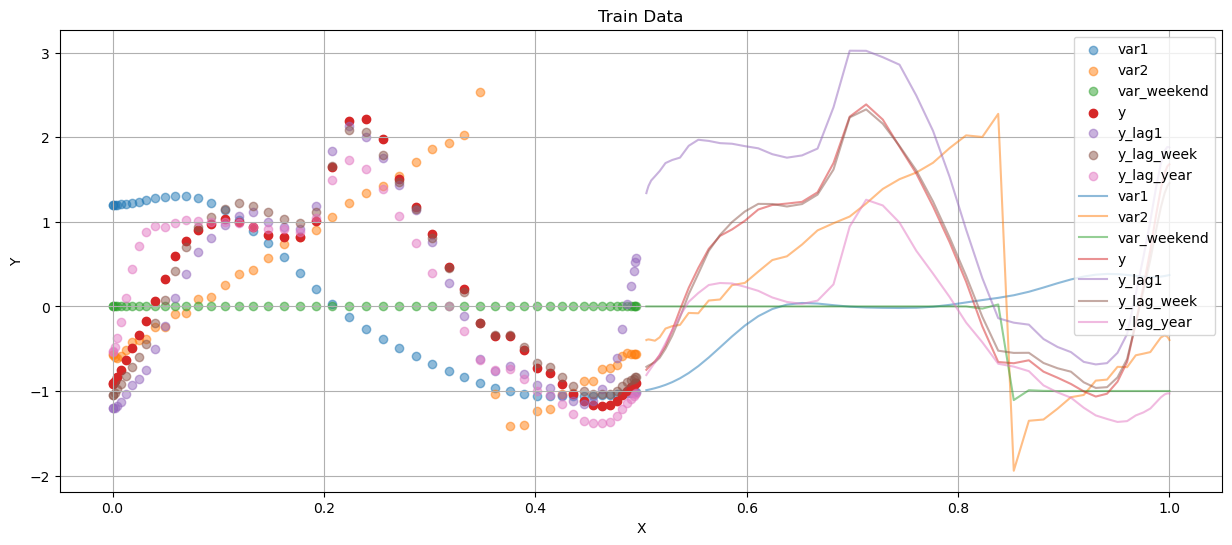

In [61]:
if True:
    plt.figure(figsize=(15, 6))
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.scatter(df_train['t'], df_train[col], label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [69]:
data_subsample

,t,var1,var2,y,var_weekend
0,0.000000,12.667197,6,25416.0,1
1,0.010101,12.711712,6,26658.0,1
2,0.020202,12.787946,7,28206.0,1
3,0.030303,12.884548,7,29551.0,1
4,0.040404,12.985063,8,31180.0,1
...,...,...,...,...,...
95,0.959596,9.416568,5,26848.0,0
96,0.969697,9.361575,6,30184.0,0
97,0.979798,9.321625,6,33738.0,0
98,0.989899,9.329966,7,38095.0,0


In [75]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

layer_widths = [7, 100, 100, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

ys = jnp.atleast_2d(jnp.array(df_train['y'])).T
ts = jnp.array(df_train['t'])
Xs = jnp.array(df_train.drop(columns=['y', 't']))
extra_args = (Xs, ts)
y0 = jnp.array([ys[0]])

for k in [int(len(ys)*0.05), int(len(ys)*0.1), int(len(ys)*0.5), len(ys)]:
    state = node_model.train(state, ts[:k] 
                            , ys[:k], y0
                            , num_epochs = 50000
                            , extra_args = extra_args[:k]
                            )

Epoch 100, Loss: 0.0009888510685414076
Epoch 200, Loss: 0.0005937725654803216
Epoch 300, Loss: 0.00040579852066002786
Epoch 400, Loss: 0.00029289271333254874
Epoch 500, Loss: 0.00022127841657493263
Epoch 600, Loss: 0.00017576014215592295
Epoch 700, Loss: 0.0001471034629503265
Epoch 800, Loss: 0.00012936707935296
Epoch 900, Loss: 0.0001186112713185139
Epoch 1000, Loss: 0.00011223520414205268
Epoch 1100, Loss: 0.00010854807624127716
Epoch 1200, Loss: 0.0001064720272552222
Epoch 1300, Loss: 0.00010533713066251948
Epoch 1400, Loss: 0.0001047355035552755
Epoch 1500, Loss: 0.00010442700295243412
Epoch 1600, Loss: 0.00010427433153381571
Epoch 1700, Loss: 0.00010420159378554672
Epoch 1800, Loss: 0.00010416831355541945
Epoch 1900, Loss: 0.00010415373253636062
Epoch 2000, Loss: 0.00010414762073196471
Epoch 2100, Loss: 0.00010414519056212157
Epoch 2200, Loss: 0.00010414426651550457
Epoch 2300, Loss: 0.00010414393182145432
Epoch 2400, Loss: 0.0001041438226820901
Epoch 2500, Loss: 0.000104143786302

KeyboardInterrupt: 

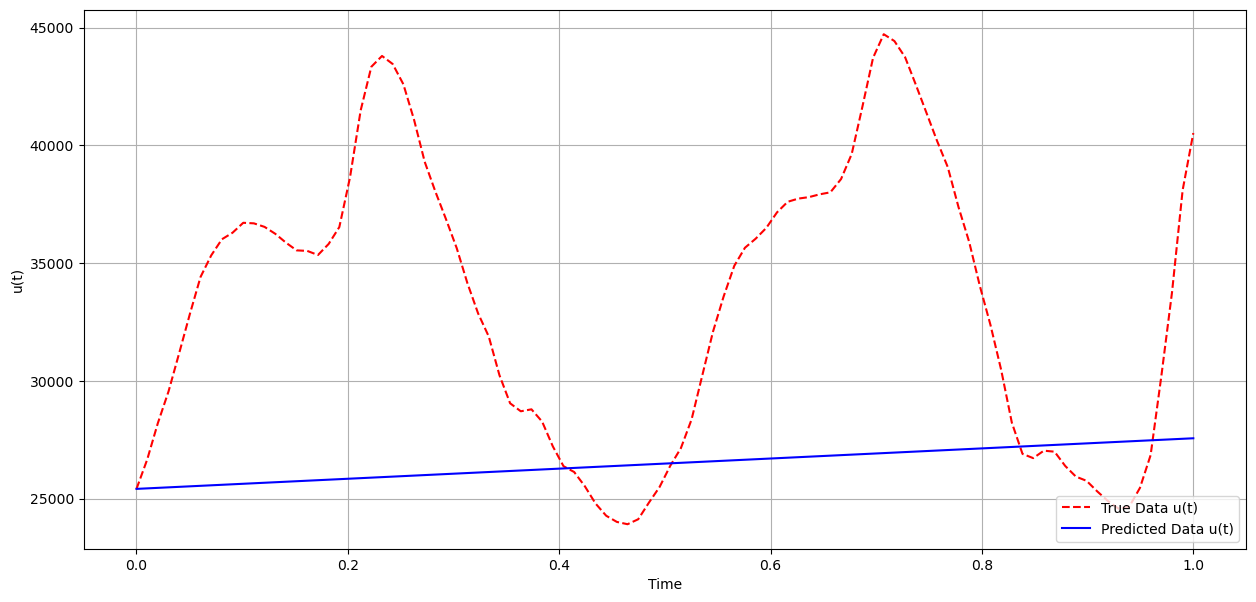

In [74]:
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, np.squeeze(y_train_pred), 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()